# Simple Linear Regression with lmfit 

In [47]:
import matplotlib.pyplot as plt
import SimpleITK as sitk
import sys, os
import numpy as np
from scipy import ndimage as ndi
import skimage as skim
from skimage import feature
import pandas as pd
import xarray as xr
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,8)
import os
import pickle as pkl
from skimage import morphology
import joypy
import lmfit as lm


In [2]:
full_data_dir = '/pghbio/dbmi/batmanlab/bpollack/predictElasticity/data/MRE/'
subjects = sorted([x for x in os.listdir(full_data_dir) if x.isdigit()])
subdir_names = ['SE00001','SE00002','SE00003','SE00004','SE00005','SE00006']
sequence_labels = ['T2SS', 'T1Pre', 'T1Pos', 'T2FR', 'elastMsk', 'elast']
extras = ['extra1', 'extra2', 'extra3', 'extra4']

In [3]:
ds = pkl.load(open(full_data_dir+'mre_ds_transform_2.p', 'rb'))

In [4]:
ds = ds.drop(['extra2','extra3','extra4'], dim='sequence')

In [5]:
df = ds.to_dataframe()

In [6]:
df.head()

images  ages
sequence slices subject x y              
T2SS     0      365     0 0     0.0    58
                          1     0.0    58
                          2     0.0    58
                          3     0.0    58
                          4     0.0    58

In [7]:
df.drop(columns='ages', inplace=True)
df.rename(columns={'images':'pixels'}, inplace=True)
df = df.unstack(0)
df.columns = df.columns.droplevel()
df.reset_index(inplace=True)
df.columns.name = None

In [8]:
df.head()

,slices,subject,x,y,T1Pos,T1Pre,T2FR,T2SS,elast,elastMsk,msk
0,0,365,0,0,4.0,6.0,4.0,0.0,0.0,0.0,0.0
1,0,365,0,1,6.0,8.0,4.0,0.0,0.0,0.0,0.0
2,0,365,0,2,6.0,8.0,3.0,0.0,0.0,0.0,0.0
3,0,365,0,3,5.0,6.0,3.0,0.0,0.0,0.0,0.0
4,0,365,0,4,6.0,6.0,4.0,0.0,0.0,0.0,0.0


In [9]:
np.random.seed(1)
df_sample = df.sample(10000)

In [10]:
df_sample.head()

,slices,subject,x,y,T1Pos,T1Pre,T2FR,T2SS,elast,elastMsk,msk
440691,0,380,185,115,114.0,223.0,194.0,81.0,1498.0,1498.0,0.0
4822723,3,396,150,195,254.0,48.0,471.0,921.0,1056.0,1056.0,0.0
4225328,3,372,121,48,468.0,181.0,402.0,63.0,2266.0,2266.0,1.0
2829603,2,371,45,35,22.0,16.0,26.0,0.0,1326.0,1326.0,1.0
434678,0,380,161,246,0.0,22.0,28.0,12.0,0.0,0.0,0.0


In [24]:
def mre_linear_function(T1Pos, T1Pre, T2FR, T2SS, A, B, C, D, E):
    return A*T1Pos + B*T1Pre + C*T2FR + D*T2SS + E

In [40]:
model = lm.Model(mre_linear_function, independent_vars=['T1Pos','T1Pre','T2FR', 'T2SS'])
params = lm.Parameters()
params.add('A', value=0.5)
params.add('B', value=0.5)
params.add('C', value=0.5)
params.add('D', value=0.5)
params.add('E', value=0)

In [42]:
result = model.fit(df_sample.elast, T1Pos=df_sample.T1Pos, T1Pre=df_sample.T1Pre,
                   T2FR=df_sample.T2FR, T2SS=df_sample.T2SS, params=params)   
print(result.fit_report())

[[Model]]
    Model(mre_linear_function)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 12
    # data points      = 10000
    # variables        = 5
    chi-square         = 2.6218e+10
    reduced chi-square = 2623148.37
    Akaike info crit   = 147803.857
    Bayesian info crit = 147839.909
[[Variables]]
    A:  1.32667175 +/- 0.07524941 (5.67%) (init = 0.5)
    B:  1.89014281 +/- 0.10527947 (5.57%) (init = 0.5)
    C:  1.59564847 +/- 0.15424943 (9.67%) (init = 0.5)
    D:  0.79838967 +/- 0.13583260 (17.01%) (init = 0.5)
    E:  961.370122 +/- 23.1987887 (2.41%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(B, D) = -0.533
    C(A, B) = -0.289
    C(A, E) = -0.279
    C(C, D) = -0.232
    C(D, E) = -0.207
    C(A, C) = -0.206
    C(C, E) = -0.201
    C(B, C) = -0.151
    C(B, E) = -0.118



In [27]:
df_365_slice1 = df.query('subject=="365" and slices==1')

In [28]:
df_365_slice1['elast_predict'] = result.eval(T1Pos=df_365_slice1.T1Pos, T1Pre=df_365_slice1.T1Pre,
                                             T2FR=df_365_slice1.T2FR, T2SS=df_365_slice1.T2SS)

/home/bpollack/conda_envs/mre/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
df_365_slice1.head()

,slices,subject,x,y,T1Pos,T1Pre,T2FR,T2SS,elast,elastMsk,msk,elast_predict
1310720,1,365,0,0,7.0,4.0,2.0,0.0,0.0,0.0,0.0,981.408692
1310721,1,365,0,1,8.0,5.0,3.0,0.0,0.0,0.0,0.0,986.221156
1310722,1,365,0,2,7.0,6.0,4.0,0.0,0.0,0.0,0.0,988.380275
1310723,1,365,0,3,7.0,7.0,4.0,0.0,0.0,0.0,0.0,990.270418
1310724,1,365,0,4,8.0,7.0,4.0,0.0,0.0,0.0,0.0,991.597090


In [30]:
df_365_slice1.columns

Index(['slices', 'subject', 'x', 'y', 'T1Pos', 'T1Pre', 'T2FR', 'T2SS',
       'elast', 'elastMsk', 'msk', 'elast_predict'],
      dtype='object')

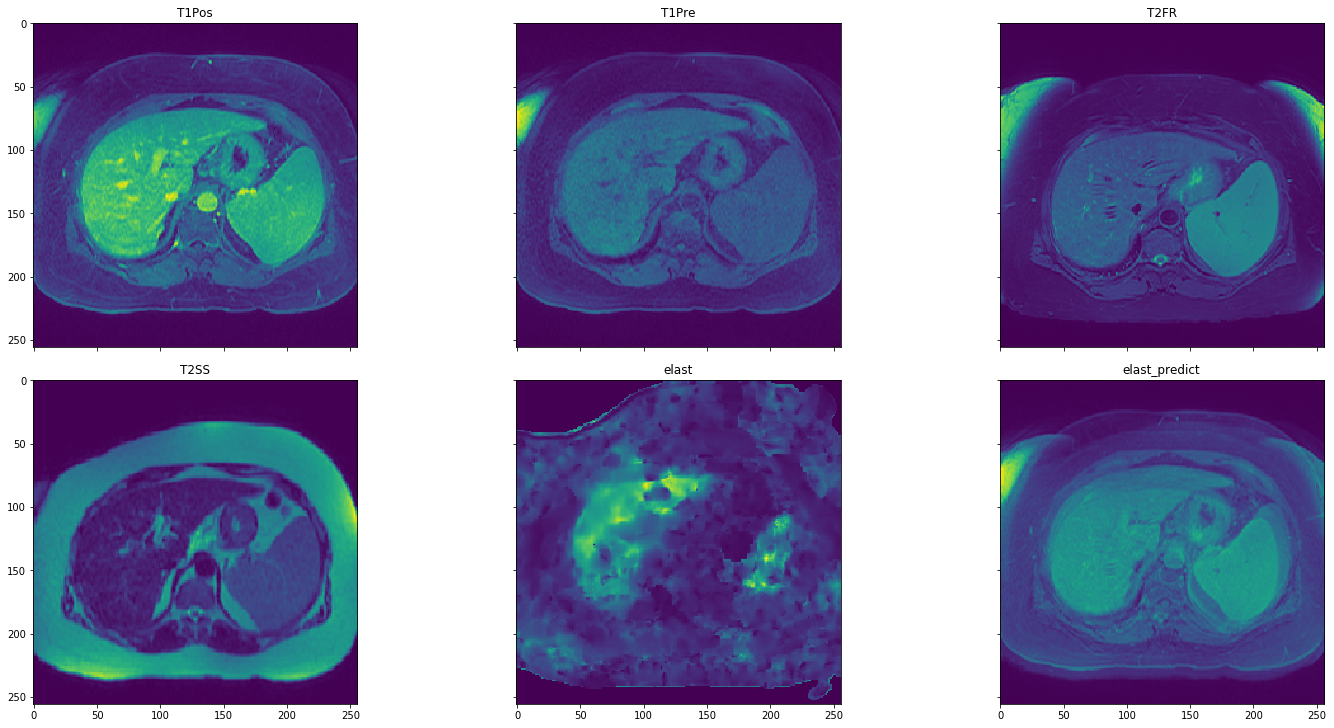

In [31]:
fig, axs = plt.subplots(2,3, constrained_layout=True, figsize=(20,10), sharex=True, sharey=True)
axs = axs.flatten()
for i, seq in enumerate(['T1Pos', 'T1Pre', 'T2FR', 'T2SS', 'elast', 'elast_predict']):
    axs[i].imshow(df_365_slice1[seq].values.reshape((256,-1)).T)
    axs[i].set_title(seq)

In [45]:
result_weight = model.fit(df_sample.elast, T1Pos=df_sample.T1Pos, T1Pre=df_sample.T1Pre,
                   T2FR=df_sample.T2FR, T2SS=df_sample.T2SS, params=params, weights=df_sample.msk)   
print(result_weight.fit_report())
df_365_slice1['elast_predict_weight'] = result_weight.eval(T1Pos=df_365_slice1.T1Pos, T1Pre=df_365_slice1.T1Pre,
                                             T2FR=df_365_slice1.T2FR, T2SS=df_365_slice1.T2SS)

[[Model]]
    Model(mre_linear_function)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 12
    # data points      = 10000
    # variables        = 5
    chi-square         = 1.1955e+10
    reduced chi-square = 1196118.61
    Akaike info crit   = 139950.923
    Bayesian info crit = 139986.974
[[Variables]]
    A:  0.83354360 +/- 0.07626746 (9.15%) (init = 0.5)
    B:  2.50528559 +/- 0.11392114 (4.55%) (init = 0.5)
    C:  1.53414304 +/- 0.16191775 (10.55%) (init = 0.5)
    D: -1.12800602 +/- 0.15215397 (13.49%) (init = 0.5)
    E:  2183.68488 +/- 31.4658773 (1.44%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(B, D) = -0.592
    C(A, E) = -0.367
    C(D, E) = -0.298
    C(A, B) = -0.290
    C(C, E) = -0.245
    C(A, D) =  0.170
    C(B, C) = -0.166
    C(A, C) = -0.143
    C(C, D) = -0.118
    C(B, E) = -0.102



/home/bpollack/conda_envs/mre/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


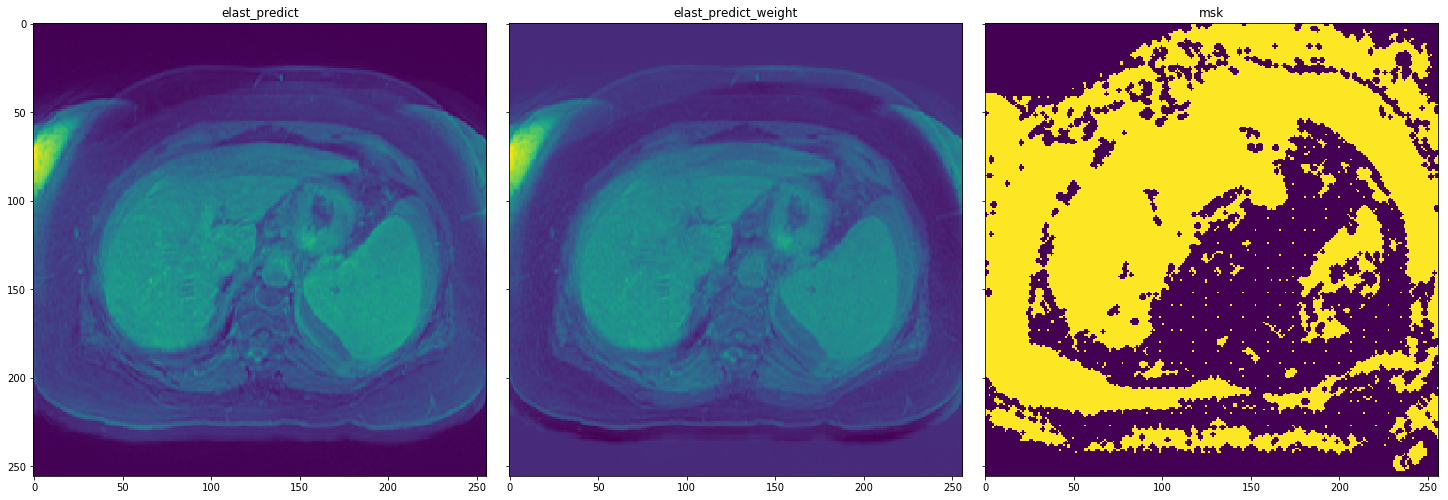

In [46]:
fig, axs = plt.subplots(1,3, constrained_layout=True, figsize=(20,10), sharex=True, sharey=True)
axs = axs.flatten()
for i, seq in enumerate(['elast_predict', 'elast_predict_weight', 'msk']):
    axs[i].imshow(df_365_slice1[seq].values.reshape((256,-1)).T)
    axs[i].set_title(seq)